## Using Transfer Learning to Predict Dog Breed
(Note: This experiment inspired by Chapter 2 of Deep Learning with PyTorch, Stevens et al., Manning 2020)

<p>Deep neueral networks with a large number of parameters require significant time and energy resources to train. For that reason, as more large networks are trained, there is a premium on reusing them. Transfer learning is an increasingly popular method of reusing pre-trained models whereby the layer or layers closest to the output layer are removed - a maneuver known as detaching the head of the network - and replaced by a multidimensional array of the correct size, containing the desired input data. The technique is made possible because the earlier layers of the network have learned to identify general patterns in the data, which only grow more identifiable at successively deeper layers.</p>
<p>This notebook uses a popular pre-trained model that was trained to very high accuracy on the famous ImageNet dataset to predict the breed of a dog of known mixed-breed ancestry. ImageNet consists of over 14 million images representing 20,000 distinct classes. Conveniently, 120 of these distinct classes correspond to unique dog breeds - so in essence, a model trained on ImageNet is ready to predict dog breeds out-of-the-box. Since the dog we'll pass into the model is a mutt, the classification task is not well-defined here, but as an unsupervised experiment it is intstructive.</p>

In [145]:
from torchvision import models
from torchvision import transforms
import torch
from PIL import Image
from pathlib import Path
import pandas as pd

# fastai is only used for conveniently displaying images
from fastai import *
from fastai.vision.all import *

The resnet series of DNNs, which come in a variety of layer depths, are very popular for computer vision tasks. We will use PyTorch's pre-trained resnet NN with 101 layers:

In [146]:
resnet = models.resnet101(pretrained=True)

The next cell defines a function that will prepare each image to be used as an input in the NN.

In [148]:
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])

We can peek at a sample image of our test subject, Cricket:

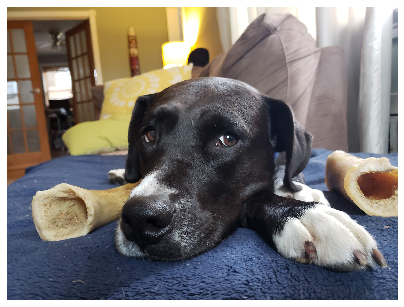

In [147]:
crick = Image.open("/Users/bill/Desktop/crick_close.jpg")
show_image(crick, figsize=(7,7))

This code block processes the image above and passes it into the NN:

In [163]:
crick_t = preprocess(crick)
batch_t = torch.unsqueeze(crick_t, 0)
resnet.eval()
out = resnet(batch_t)

Next:
1. Load the labels for the photos that ImageNet was trained on.
2. Use the labels to display the top 5 suggestions by the network, with normalized confidence

In [164]:
with open('../data/p1ch2/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('Great Dane', 2.2356412410736084),
 ('German short-haired pointer', 0.05516194552183151),
 ('Labrador retriever', 0.3681313991546631),
 ('Doberman, Doberman pinscher', 0.01201793272048235),
 ('bluetick', 0.011052682064473629)]

<p>According to this one photo, the model is 73% 'sure' that Cricket is a Great Dane. Officially, Cricket's adoption papers listed her as a Labrador / Great Dane mix. Furthermore, people sometimes, but not always, wonder if she is part pit bull. I've always leaned toward her having some labrador, some pit bull, maybe some pointer. She's only about 2/3 the size of a quite small Great Dane, so I have my doubts about that.</p>
The next loop looks at 5 different images and prints the results.

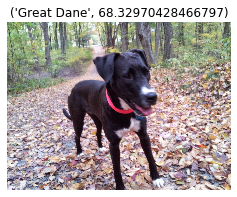

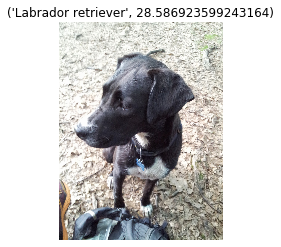

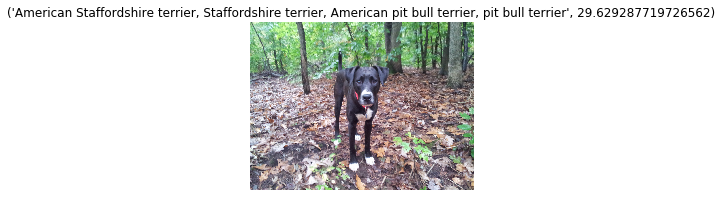

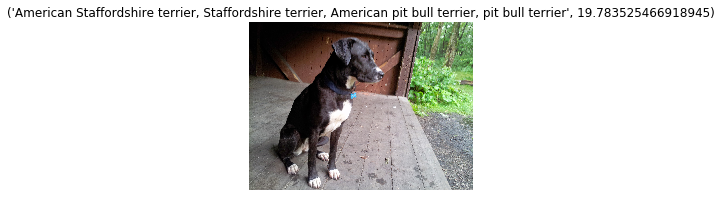

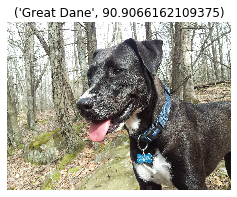

In [171]:
paths = Path(r'/Users/bill/Desktop/Ind_Study/dlwpt-code/Crick_pics').glob('**/*.jpg')
outs = []
for path in paths:
    # because path is object not string
    path_in_str = str(path)
    # Do thing with the path
    img = Image.open(path)
    img_c = preprocess(img)
    batch_c = torch.unsqueeze(img_c, 0)
    out_crick2 = resnet(batch_c)
    _, index = torch.max(out_crick2, 1)
    percentage = torch.nn.functional.softmax(out_crick2, dim=1)[0] * 100
    title = labels[index[0]], percentage[index[0]].item()
    outs.append(title)
    show_titled_image((img, title), figsize=(4,4))

This is about what I would have expected! Except that the confidence levels for Great Dane are quite high. The next loop passes in 197 images of Cricket and builds a list of the model's predictions, which is then transformed into a pandas DataFrame.

In [172]:
paths = Path(r'/Users/bill/Desktop/Crick').glob('**/*.jpg')
outs = []
for path in paths:
    # because path is object not string
    path_in_str = str(path)
    # Do thing with the path
    img = Image.open(path)
    img_c = preprocess(img)
    batch_c = torch.unsqueeze(img_c, 0)
    out_crick2 = resnet(batch_c)
    _, index = torch.max(out_crick2, 1)
    percentage = torch.nn.functional.softmax(out_crick2, dim=1)[0] * 100
    title = labels[index[0]], percentage[index[0]].item()
    outs.append(title)

out_df = pd.DataFrame(outs, columns=['Breed', 'Confidence'])
df = pd.DataFrame(out_df.groupby('Breed')['Confidence'].sum()).sort_values(by=['Confidence'], ascending=False)
counts = out_df.groupby('Breed').count().rename(columns={'Confidence':'Count'})
df = pd.merge(df, counts, how='left', on='Breed')
df.head()

,Confidence,Count
Breed,,
Great Dane,2844.310066,50
"Staffordshire bullterrier, Staffordshire bull terrier",1832.610334,35
"American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier",1379.413540,29
Labrador retriever,815.286404,17
Italian greyhound,741.873045,13


The top 5 breed suggestions are diplayed above with the number of images by breed ('Count'), as well as the weighted sum of the confidence for that breed. <p>One problem remains: ImageNet seems to have had separate labels for what are considered to be the same breed: Staffordshire Terrier and American Pit Bull Terrier. So we need to combine these rows. Lets also add a column to look at the mean confidence per breed (in addition to the aggregate confidence).<p/>

In [173]:
df.loc['America pit bull terrier'] = df.loc['Staffordshire bullterrier, Staffordshire bull terrier',:] + \
    df.loc['American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',:]
df = df.drop(['Staffordshire bullterrier, Staffordshire bull terrier',
             'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier'])

df = df.sort_values(by='Confidence', ascending=False)
df['Mean_Confidence'] = df['Confidence']/df['Count']

Finally, let's have a look at all of the predictions:

In [174]:
df

,Confidence,Count,Mean_Confidence
Breed,,,
America pit bull terrier,3212.023874,64.0,50.187873
Great Dane,2844.310066,50.0,56.886201
Labrador retriever,815.286404,17.0,47.958024
Italian greyhound,741.873045,13.0,57.067157
whippet,320.391678,8.0,40.048960
magpie,193.355268,3.0,64.451756
"Boston bull, Boston terrier",179.362074,6.0,29.893679
sea lion,165.665230,3.0,55.221743
"cliff, drop, drop-off",165.019859,3.0,55.006620


A few salient points:
1. The most often predicted breed is Pit Bull.
2. Great Dane has slightly fewer prediction counts, but the mean confidence per prediction is higher.
3. These two breeds account for 114/197 of the total number of predictions - about 58%
4. The rest of the predictions depict a distribution with an increasingly long tail of outlandish predictions.  
5. It's worth noting that, in selecting input photos, a lenient policy was used. In other words, many of the photos may have failed to return a meaningful prediction simply because of the angle, or lighting, etc. Despite that, we've demonstrated that a pre-trained model can do quite well in suggesting the breed of a mixed-breed dog, without any fine-tuning. This is the kind of result that would not have been imaginable in so little code a few short years ago.